# Neural Networks :  Problem 2
## Prediction by Backward Propogation

## Disclaimer
These exercises are based on the Stanford Machine Learning Course [CS229](http://cs229.stanford.edu) of Andrew Ng. The environment of the exercise have been tuned to the theory content taught at Ravensburg Weingarten University.

We are using the Python programming language. If you don't know Python or if you would like to refresh your memory, take a look at the [Python tutorial](http://docs.python.org/tut/).
We will mostly work with NumPy, the fundamental package for scientific computing in Python. Please read the [NumPy quickstart tutorial](https://numpy.org/devdocs/user/quickstart.html). In addition, the documention of MatPlotLib and Scipy lib can be found here: .[MatplotLib](https://matplotlib.org/). [Scipy](https://docs.scipy.org/doc/scipy/reference/tutorial/).

In [1]:

# Used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np

# Plotting library
from matplotlib import pyplot

# Optimization module in scipy
from scipy import optimize

# will be used to load MATLAB mat datafile format
from scipy.io import loadmat

# for plotting grayscale
from PIL import Image

In the previous example, we used Feed Forward algorithm to predict the class of an input object. For this problem also, we use the same dataset to work our way backwards.

### Dataset : 
The dataset contains 5000 training examples of handwritten digits (This is a subset of the MNIST handwritten digit dataset). As the baseline of this problem is mentioned before, the data set has been saved in a native Octave/MATLAB matrix format. We use the .mat format here because this is the exact same dataset provided in the MATLAB version of mentioned source assignments. The good news is that Python provides mechanism to load the dataset in given format using the **scipy.io** module. This function returns a python dictionary with keys containing the variable names within the .mat file. The dataset can be downloaded from : 

Simply use the below snippet of code to extract the data.

In [2]:
#  training data stored in arrays X, y
data = loadmat('./ex4data1.mat')

X, y = data['X'], data['y'].ravel()
m = y.size

print('Total size of dataset is {} images'.format(m))

Total size of dataset is 5000 images


There are 5000 training examples in the given dataset. Each training example is a 20 pixel by 20 pixel grayscale image. Each pixel is represented by a floating point number indicating the grayscale intensity of the pixel. The 20 by 20 grid of pixels is “flattened” into a 400-dimensional vector. As a result, each of the training examples becomes a single row in our data matrix **X**. This gives us size 5000 by 400 matrix X.

$$ X = \begin{bmatrix} - \: (x^{(1)})^T \: - \\ -\: (x^{(2)})^T \:- \\ \vdots \\ - \: (x^{(m)})^T \:-  \end{bmatrix} $$

The second part of the training set is a 5000-dimensional vector y that contains labels for the training set.

**Here's a small modification to be done**. Since the original dataset was in .mat format and MATLAB doesn't have 0 indexing, the digit zero is mapped to ouput (y) = 10. Before moving further, we have to map the digit zero to output (y) = 0.

In [3]:
# Setting the zero digit to 0.
# This is an artifact due to the fact that this dataset was used in...
# ...MATLAB where there is no index 0
y[y == 10] = 0

### Visualize Dataset

Let us begin by visualizing a subset of the training set. We plot take a random integer out of the total size of our dataset i.e. 5000 images. This index is passed to the **show_img** function to produce a grayscale image. The function works as follows: First it extract the whole row with the specified index from the X matrix. This need to be put in original shape to display correctly. Lets call this process as 'unflattening'. Here the row vector is reshaped to its original shape 20 by 20. This is done by Numpy **reshape** command. Here we use the Fortran indexing order to stack the row elements as per correct order. (Otherwise you see an incorrect image). Further, out input vector is in form of floating point numbers ranging from 0 to 1. For plotting Grayscale Image these need to be scaled to a factor of 0 to 255. 

Use the PIL library to plot the image. [PIL](https://pillow.readthedocs.io/en/stable/reference/Image.html)
The image is rescaled to get better visualization.

Size of image is : (512, 512)


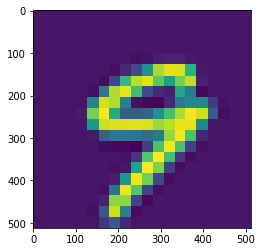

In [4]:
# Choose a random index
rand_indices = np.random.choice(m, 1)

def show_img(a):

    # Select the row from X matrix with the specified argument
    selc = X[a, :]

    # Unflatten the row to original 20x20 size
    selc = np.reshape(selc, (20,20), order='F')
    
    # Multiply by 255 to get a grayscale range in 0 to 255
    im = Image.fromarray(selc*255)

    # Increase the size for better visualization
    size = (512,512)
    im = im.resize(size)
    pyplot.imshow(im)
    
    print('Size of image is : {}'.format(size))


show_img(rand_indices)

### Model Representation and Feedforward Prediction

Our understanding of Neural Network is shown in the following figure.
<img src='./graphic/sample.png' width='350' height='350'>

It has 3 layers: Input layer, Hidden layer and Output layer. Note that our inputs **X** are pixel values of digit images. Since the images are of size 20×20, this gives us 400 Input layer units. 

You are provided with a set of network parameters ($\Theta^{(1)}$, $\Theta^{(2)}$) already trained by Standford Uni. They are stored in `ex4weights.mat`. Let us load those parameters into variables `Theta1` and `Theta2`. The parameters have dimensions that are sized for a neural network with 25 units in the second layer and 10 output units (corresponding to the 10 digit classes). Note that each of the two weight matrix have one column extra.

**Why ?** Remember Bias terms !

In [5]:
# Setup the parameters you will use for this exercise
input_layer_size  = 400  # 20x20 Input Images of Digits
hidden_layer_size = 25   # 25 hidden units
num_labels = 10          # 10 labels, from 0 to 9

# Load the .mat file, which returns a dictionary 
weights = loadmat('./ex4weights.mat')

# get the model weights from the dictionary
# Theta1 has size 25 x 401
# Theta2 has size 10 x 26
Theta1, Theta2 = weights['Theta1'], weights['Theta2']

print('Size of Weight-Vector for Hidden Layer is: {} '.format(Theta1.shape))
print('Size of Weight-Vector for Output Layer is: {} '.format(Theta2.shape))


Size of Weight-Vector for Hidden Layer is: (25, 401) 
Size of Weight-Vector for Output Layer is: (10, 26) 


In [6]:

# Swap first and last columns of Theta2, due to legacy from MATLAB indexing, 
# Since the weight file ex3weights.mat was saved based on MATLAB indexing
Theta2 = np.roll(Theta2, 1, axis=0)

# Unroll parameters to inclue all information in 1 array. Two vector can be separatd later based on sizes.
nn_params = np.concatenate([Theta1.ravel(), Theta2.ravel()])

**What do we do to calculate $h_\theta(x^{(i)})$ ?**

We apply a non-linear function after linear transformation. That means:

$$
h(x) = f(dot.product(W,x))
$$

where b is the Bias term.
We have earlier seen the dimensions of our pre-given weight matrices. Note that the bias term is already included in it. We have two options: (1) We can increment the input vector X by a row of 1s or (2) We can split the computation as shown in the equation below.

$$
h(x) = f(Wx + b)
$$

Unlike the previous part, we resort to the first option for this problem. This saves us computation time as loops are avoided. Since we have a two layer Neural network, we have to apply this $h$ function twice. 

$$
h_\theta(x) = f_2(dot(W_2,f_1(dot(W_1,x))))
$$

**Caution: Don't forget to increment the input vector X by a row of 1s**

**What is f function ?**
For Neural Networks, there are many activations function f, as you can see in the picture shown below. But out of these a famous one is the Sigmoid Function. We use this one for our problem here. The sigmoid function computes the probabibility of each class and we can choose the output class with the max value of computed probabilities.
<img src='./graphic/2.png' width='550' height='550'>

### 2.A Feedforward Cost Function

Now you will implement the cost function and gradient for the neural network. First, complete the code for the function `nnCostFunction` in the next cell to return the cost.

The cost function for the neural network (without regularization) is:

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m}\sum_{k=1}^{K} \left[ - y_k^{(i)} \log \left( \left( h_\theta \left( x^{(i)} \right) \right)_k \right) - \left( 1 - y_k^{(i)} \right) \log \left( 1 - \left( h_\theta \left( x^{(i)} \right) \right)_k \right) \right]$$

where $h_\theta \left( x^{(i)} \right)$ is computed as shown in the neural network figure above, and K = 10 is the total number of possible labels. Note that $h_\theta(x^{(i)})_k = a_k^{(3)}$ is the activation (output
value) of the $k^{th}$ output unit. Also, recall that whereas the original labels (in the variable y) were 0, 1, ..., 9, for the purpose of training a neural network, we need to encode the labels as vectors containing only values 0 or 1, so that

$$ y = 
\begin{bmatrix} 1 \\ 0 \\ 0 \\\vdots \\ 0 \end{bmatrix}, \quad
\begin{bmatrix} 0 \\ 1 \\ 0 \\ \vdots \\ 0 \end{bmatrix}, \quad \cdots  \quad \text{or} \qquad
\begin{bmatrix} 0 \\ 0 \\ 0 \\ \vdots \\ 1 \end{bmatrix}.
$$

For example, if $x^{(i)}$ is an image of the digit 5, then the corresponding $y^{(i)}$ (that you should use with the cost function) should be a 10-dimensional vector with $y_5 = 1$, and the other elements equal to 0.

You should implement the feedforward computation that computes $h_\theta(x^{(i)})$ for every example $i$ and sum the cost over all examples. **Your code should also work for a dataset of any size, with any number of labels** (you can assume that there are always at least $K \ge 3$ labels).

In [7]:
def sigmoid(z):
    
    # Computes the sigmoid of z.
    
    return 1.0 / (1.0 + np.exp(-z))

In [8]:
def nnCostFunction(nn_params,input_layer_size,hidden_layer_size,num_labels, X, y, lambda_=0):
    
    # Exract the 2 weight vectors based on layer sizes, this can be used a general rule.
    Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
                        (hidden_layer_size, (input_layer_size + 1)))

    Theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):],
                        (num_labels, (hidden_layer_size + 1)))

    # Size of dataset
    m = y.size
         
    # Compute the Cost as per above formula
    J = 0
    
    # Neural Network activations...
    
    a1 = np.concatenate([np.ones((m, 1)), X], axis=1) # adding row of 1s
    a2 = sigmoid(a1.dot(Theta1.T)) # first dot product and then func application
    
    
    a2 = np.concatenate([np.ones((a2.shape[0], 1)), a2], axis=1) # adding bias term again in hidden layer
    a3 = sigmoid(a2.dot(Theta2.T))
    
    # Modifying Output matrix as per above explanation
    y_matrix = y.reshape(-1)
    y_matrix = np.eye(num_labels)[y_matrix]
 
    # Compute J
    J = (-1. / m) * np.sum((np.log(a3) * y_matrix) + np.log(1 - a3) * (1 - y_matrix))
    
    # Gradients are just initiliazed, we complete them later in this Notebook
    Theta1_grad = np.zeros(Theta1.shape)
    Theta2_grad = np.zeros(Theta2.shape)
    grad = np.concatenate([Theta1_grad.ravel(), Theta2_grad.ravel()])
    
    return J, grad

Once you are done, call your nnCostFunction using the loaded set of parameters for Theta1 and Theta2. You should see that the cost is about 0.2876.

In [9]:
lambda_ = 0
J, _ = nnCostFunction(nn_params, input_layer_size, hidden_layer_size,
                   num_labels, X, y, lambda_)
print('Cost at parameters (loaded from ex4weights): %.6f ' % J)

Cost at parameters (loaded from ex4weights): 0.287629 


### 2.B Random Initialization

When training neural networks, it is important to randomly initialize the parameters for symmetry breaking. One effective strategy for random initialization is to randomly select values for $\Theta^{(l)}$ uniformly in the range $[-\epsilon_{init}, \epsilon_{init}]$. A default value of $\epsilon_{init} = 0.12$ can be used. This range of randomly initialized Theta(s) ensures that the parameters are kept small and makes the learning more efficient.

Your job is to complete the function `rand_init_weight` to initialize the weights for $\Theta$. Modify the function by filling in the following code:

```python
# Randomly initialize the weights to small values
W = np.random.rand(L_out, 1 + L_in) * 2 * epsilon_init - epsilon_init
```

In [10]:
def rand_init_weight(L_in, L_out, epsilon_init=0.12):

    # L_in = number of incoming connections
    # L_in = number of outgoing connections

    W = np.zeros((L_out, 1 + L_in))

    W = np.random.rand(L_out, 1 + L_in) * 2 * epsilon_init - epsilon_init

    return W

In [11]:
print('Initializing Neural Network Parameters ...')

initial_Theta1 = rand_init_weight(input_layer_size, hidden_layer_size)
initial_Theta2 = rand_init_weight(hidden_layer_size, num_labels)

# Unroll parameters to inclue all information in 1 array. Two vector can be separatd later based on sizes.
initial_nn_params = np.concatenate([initial_Theta1.ravel(), initial_Theta2.ravel()], axis=0)

print('Initialization done.')

Initializing Neural Network Parameters ...
Initialization done.


### 2.C Backpropagation

We will now implement the backpropagation algorithm to compute the gradient for the neural network cost function. First, read the theory recall given below and write the functions for Theta 1 gradient and Theta 2 gradient. After that, update the function `nnCostFunction` so that it returns an appropriate value for `grad`. Once you have computed the gradient successfully, you will be able to train the neural network by minimizing the cost function $J(\theta)$ using an advanced optimizer such as `scipy`'s `optimize.minimize`.


### Sigmoid Gradient

For the process of backpropogation, we should first closely look at the sigmoid gradient function. The gradient for the sigmoid function will be used in below computations and it is a good idea to computed it: 

$$ g'(z) = \frac{d}{dz} g(z) = g(z)\left(1-g(z)\right) $$

where

$$ \text{sigmoid}(z) = g(z) = \frac{1}{1 + e^{-z}} $$

Now complete the implementation of `sigmoidGradient` in the next cell.

In [12]:
def sigmoid_grad(z):
    # Grad of Sigmoid func can be written as g'(z) = g(z) * (1-g(z))

    g = np.zeros(z.shape)
    g = sigmoid(z) * (1 - sigmoid(z))
    
    return g

When you are done, the following cell call `sigmoidGradient` on a given vector `z`. Try testing a few values by calling `sigmoidGradient(z)`. For large values (both positive and negative) of z, the gradient should be close to 0. When $z = 0$, the gradient should be exactly 0.25. Your code should also work with vectors and matrices. For a matrix, your function should perform the sigmoid gradient function on every element.

In [13]:
z = np.array([-1, -0.5, 0, 0.5, 1])
g = sigmoid_grad(z)
print('Sigmoid gradient evaluated at [-1 -0.5 0 0.5 1]:\n  ')
print(g)

Sigmoid gradient evaluated at [-1 -0.5 0 0.5 1]:
  
[0.19661193 0.23500371 0.25       0.23500371 0.19661193]


### Theory
Revise that the intuition behind the backpropagation algorithm. Given a training example  (𝑥(𝑡),𝑦(𝑡)) , we will first run a “forward pass” to compute all the activations throughout the network, including the output value of the hypothesis  ℎ𝜃(𝑥) . Then, for each node  𝑗  in layer  𝑙 , we compute an “error term”  𝛿(𝑙)𝑗  that measures how much that node was “responsible” for any errors in our output.

For an output node, we can directly measure the difference between the network’s activation and the true target value, and use that to define $\delta_j^{(3)}$ (since layer 3 is the output layer). For the hidden units, you will compute $\delta_j^{(l)}$ based on a weighted average of the error terms of the nodes in layer $(l+1)$. In detail, here is the backpropagation algorithm. Step 5 will divide the accumulated gradients by $m$ to obtain the gradients for the neural network cost function.

1. Perform a feedforward pass, computing the activations $(z^{(2)}, a^{(2)}, z^{(3)}, a^{(3)})$ for layers 2 and 3. You have already done this part above while compute the Cost function.

1. For each output unit $k$ in layer 3 (the output layer), set 
$$\delta^{(3)} = \left(a^{(3)} - y \right)$$
where $y_k \in \{0, 1\}$ indicates whether the current training example belongs to class $k$ $(y_k = 1)$, or if it belongs to a different class $(y_k = 0)$.

1. For the hidden layer $l = 2$, set 
$$ \delta^{(2)} = \left( \Theta^{(2)} \right)^T \delta^{(3)} * g'\left(z^{(2)} \right)$$
Note that the symbol $*$ performs element wise multiplication in `numpy`.  Also you should chuck the bias term of from the Weight vector.

1. Accumulate the gradient from this example using the following formula. 
$$ \Delta^{(l)} = \delta^{(l+1)} (a^{(l)})^{(T)} $$

1. Obtain the gradient for the neural network cost function by dividing the accumulated gradients by $\frac{1}{m}$:
$$ \frac{\partial}{\partial \Theta_{ij}^{(l)}} J(\Theta) = D_{ij}^{(l)} = \frac{1}{m} \Delta_{ij}^{(l)}$$



In [14]:
def nnCostFunction(nn_params,input_layer_size,hidden_layer_size,num_labels, X, y, lambda_=0):
    
    # Exract the 2 weight vectors based on layer sizes, this can be used a general rule.
    Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
                        (hidden_layer_size, (input_layer_size + 1)))

    Theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):],
                        (num_labels, (hidden_layer_size + 1)))

    # Size of dataset
    m = y.size
         
    # Compute the Cost as per above formula
    J = 0
    
    # Neural Network activations...
    
    a1 = np.concatenate([np.ones((m, 1)), X], axis=1) # adding row of 1s
    a2 = sigmoid(a1.dot(Theta1.T)) # first dot product and then func application
    
    
    a2 = np.concatenate([np.ones((a2.shape[0], 1)), a2], axis=1) # adding bias term again in hidden layer
    a3 = sigmoid(a2.dot(Theta2.T))
    
    # Modifying Output matrix as per above explanation
    y_matrix = y.reshape(-1)
    y_matrix = np.eye(num_labels)[y_matrix]
 
    # Compute J
    J = (-1. / m) * np.sum((np.log(a3) * y_matrix) + np.log(1 - a3) * (1 - y_matrix))
    
    # Gradients are initiliazed
    Theta1_grad = np.zeros(Theta1.shape)
    Theta2_grad = np.zeros(Theta2.shape)
    
    # Backpropogation
    delta_3 = a3 - y_matrix # step 2
    delta_2 = delta_3.dot(Theta2)[:, 1:] * sigmoid_grad(a1.dot(Theta1.T)) # step 3
    
    # step 4
    Delta1 = delta_2.T.dot(a1)
    Delta2 = delta_3.T.dot(a2)
    
    # step 5
    Theta1_grad = (1. / m) * Delta1
    Theta2_grad = (1. / m) * Delta2
    
    grad = np.concatenate([Theta1_grad.ravel(), Theta2_grad.ravel()])
    
    return J, grad


### Learning parameters using `scipy.optimize.minimize`

After you have successfully implemented the neural network cost function
and gradient computation, the next step we will use `scipy`'s minimization to learn a good set parameters.

In [15]:
#  After you have completed the assignment, change the maxiter to a larger
#  value to see how more training helps.
options= {'maxiter': 100}

#  You could also try different values of lambda
lambda_ = 1

# Create "short hand" for the cost function to be minimized
costFunction = lambda p: nnCostFunction(p, input_layer_size, hidden_layer_size, num_labels, X, y, lambda_)

# Now, costFunction is a function that takes in only one argument
# (the neural network parameters)
res = optimize.minimize(costFunction, initial_nn_params, jac=True, method='TNC', options=options)

# get the solution of the optimization
nn_params = res.x

print('Model Trained.')
        
# Obtain Theta1 and Theta2 back from nn_params
new_Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)], (hidden_layer_size, (input_layer_size + 1)))

new_Theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):], (num_labels, (hidden_layer_size + 1)))


Model Trained.


### 2.D Prediction Accuracy

In [16]:
def predict(Theta1, Theta2, X):
    
    # Useful values
    m = X.shape[0]

    # You need to return the following variables correctly
    p = np.zeros(m)
    h1 = sigmoid(np.dot(np.concatenate([np.ones((m, 1)), X], axis=1), Theta1.T))
    h2 = sigmoid(np.dot(np.concatenate([np.ones((m, 1)), h1], axis=1), Theta2.T))
    p = np.argmax(h2, axis=1)
    return p

pred = predict(new_Theta1, new_Theta2, X)
print('Training Set Accuracy: %f' % (np.mean(pred == y) * 100))
#print('Accuracy of trained model is {}%'.format((1-err/m)*100))

Training Set Accuracy: 94.900000


## What can you contribute further to this Notebook ?